## Algoritmo genético

In [2137]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from sympy import symbols, sympify, lambdify
import time


In [2138]:
doc2 = open("C:/Users/antoc/Downloads/PortableGit/practica2024/hub_data.txt")
lineas2 = doc2.readlines()

H_0= 70

# Divide cada línea en columnas usando espacio como separador
datos_separados2 = [linea.strip().split(' ') for linea in lineas2]

datos= []
for fila in datos_separados2:
    datos.append(fila)

z = []
for i in range(len(datos)):
      a = float(datos[i][0])
      z.append(a)
z =np.array(z)

H = []
for i in range(len(datos)):
   if datos[i][1] == '':
      a = float(datos[i][2])
      H.append(a)
   else:
      a = float(datos[i][1])
      H.append(a)
H = np.array(H)

desv = []
for i in range(len(datos)):
    a = float(datos[i][2])
    desv.append(a)


Se minimiza $$\chi^2 = \sum_{i=1}^{N} (\dfrac{y_i - f(x_i)}{\sigma_{i}})^2$$ para obtener la función $f(x)$ que mejor se ajuste a los datos.


In [2139]:
def expo(x):
    return np.exp(x)
def ln(x):
    return np.log(x)
def poli1(x):
    return x 
def poli2(x):
    return x**2
def poli3(x):
    return x**3

grammar = [expo, ln, poli1, poli2, poli3]
operaciones = ['+', '-', '*', '/', '**']

#A partir de las funciones ingresadas inicialmente, calcula el chi_2
def chi_2_valores(f):
    return np.square((H - f(z))/desv)

def chi_2_f(f):
    chi_2_val = np.zeros_like(f)
    chi_2 = np.zeros_like(f)
    for i in range(len(f)):
        chi_2_val[i] = chi_2_valores(f[i])
        for j in range(len(chi_2_val)):
            chi_2[j] = np.sum(chi_2_val[j])
    
    return chi_2

print(chi_2_f(grammar))
chi_inic = chi_2_f(grammar)

[4157.01591713639 4430.910574765109 4318.165617110693 4300.926784511239
 4239.109972002022]


### Combinar la función inicial
Se combinan las funciones iniciales con operaciones entre ellas hasta que sean 1000 funciones iniciales.

In [2140]:
def juntar_elementos_inicial(funciones, operaciones, longitud_final=1000):
    final = []
    while len(final) < longitud_final * 3:
        random_funcion1 = random.choice(funciones)
        random_funcion2 = random.choice(funciones)
        random_operador = random.choice(operaciones)

        final.append(random_funcion1)
        final.append(random_operador)
        final.append(random_funcion2)

    # Crear una lista de sublistas para representar las filas
    resultado_final_inicial = [final[i:i+3] for i in range(0, len(final), 3)]

    return resultado_final_inicial

resultado_final_inicial = juntar_elementos_inicial(grammar, operaciones)

#for fila in resultado_final_inicial:
#    print(fila)



### Convertir la lista a función
Se definen funciones para para convertir una lista de funciones y strings (operaciones) en una función.

In [2141]:

#x deben estar entre paréntesis para no confundir con otros x en el string
def a_string(funcion):
    if funcion == expo:
        return 'exp(x)'
    elif funcion == ln:
        return 'log(x)'
    elif funcion == poli1:
        return '(x)'
    elif funcion == poli2:
        return '(x)**2'
    elif funcion == poli3:
        return '(x)**3'
    else:
        return str(funcion)

x = symbols('x')
def pasar_a_funcion(expresion):
    a_sympy = sympify(expresion)
    a_python = lambdify(x, a_sympy, 'numpy')
    return a_python

#print(pasar_a_funcion('exp(x**2)'))(2)
def composicion(lista):
    modi_int = a_string(lista[-1])
    #print(modi_int)
    for i in range(2,len(lista)+1):
        modi_ext = a_string(lista[-i])
        modi_int = modi_ext.replace('(x)', '('+ modi_int +')' )
    return modi_int

print(composicion([expo, ln, poli2]))

def convertir_lista_a_str(lista):
    string=''
    for i in range(len(lista)):
        if callable(lista[i]):
            if i != 0 and callable(lista[i - 1]):
                string = string
            elif i < len(lista) - 1 and callable(lista[i + 1]):
                compo = []
                for j in range(i, len(lista)):
                    if callable(lista[j]):
                        compo.append(lista[j])

                string += composicion(compo)
            
            else:  
                string += a_string(lista[i])
        else:
            string += lista[i]

    return string

#lista_prueba = [poli2, '+', poli1,'-', expo, ln, poli2 ,'-', poli1]
#funcion_prueba= convertir_lista_a_str(lista_prueba)
#print(funcion_prueba)

def convertir_lista_a_funcion(lista):
    string = convertir_lista_a_str(lista)
    func= pasar_a_funcion(string)
    return func

#print(convertir_lista_a_funcion(lista_prueba))


exp(log((x)**2))


### Calcular los $\chi^2$ de la población inicial y seleccionar las mejores funciones

In [2142]:
def mejores(resultado_final, tasa_seleccion = 0.2):
    chis =[]
    for fila in resultado_final:
        a = [convertir_lista_a_funcion(fila)]
        chi_combinaciones = chi_2_f(a)
        chis.append(chi_combinaciones)

    #print(chis)

    ''' 
    Se seleccionan elementos a combinar
    '''

    cant_sobrevivientes = tasa_seleccion*len(chis)
    cant_sobreviv = int(cant_sobrevivientes)
    #print('Cantidad de sobrevientes:' , cant_sobreviv)

    # Número de elementos más pequeños
    num_elementos = cant_sobreviv
    # Obtener los índices y valores de los elementos más pequeños en orden
    indices_valores_menores = sorted(enumerate(chis), key=lambda x: x[1])[:num_elementos]
    # Separar los índices y valores en listas distintas
    indices_menores, valores_menores = zip(*indices_valores_menores)
    print("Valores de chi de los elementos más pequeños:", valores_menores)


    f_mejores= []
    for numero in indices_menores:
        f_mejores.append(resultado_final[numero])

    return f_mejores

#mejores(resultado_final_inicial)


### Crossover
Combinar random partes de las soluciones de los padres (composición de funciones y sumar, multiplicar... una con otra).
La selección sirve para dejar pasar un cierto porcentaje, los cuales tendrán que acoplarse y mutar. O sea, el número baja con la selección pero aumenta con el crossover y mutación. Para cada elemento del crossover, salen 3 hijos que son producto de combinaciones con otros padres.

In [2148]:
def crossover(padres):
    #El primer elemento se mantiene constante (mejor chi^2)
    for i in range(1, len(padres)):
        combinar = random.choice(padres)
        combinar2 = random.choice(padres)
        combinar3 = random.choice(padres)
        # Separar funciones de operaciones para cada función que se combina con la seleccionada
        funciones_combinar = []
        for j in range(len(combinar)):
            if callable(combinar[j]):  # Verificar si es una función
                funciones_combinar.append(combinar[j])
        combinar_con = random.choice(funciones_combinar)

        funciones_combinar2 = []
        for j in range(len(combinar2)):
            if callable(combinar2[j]):  # Verificar si es una función
                funciones_combinar2.append(combinar2[j])
        combinar_con2 = random.choice(funciones_combinar2)

        funciones_combinar3 = []
        for j in range(len(combinar3)):
            if callable(combinar3[j]):  # Verificar si es una función
                funciones_combinar3.append(combinar3[j])
        combinar_con3 = random.choice(funciones_combinar3)

        numero_random = random.randint(0,1)
        hijos =padres[i]
        if numero_random == 0:
            random_operador = random.choice(operaciones)
            hijos.append(random_operador)
            hijos.append(combinar_con)
            #print(padres[i])
        else:
            hijos.append(combinar_con)
            #print(padres[i])
    return padres
#falta cambiar la función que retorna

### Mutación
tasa de mutación: 5, 10 % 
cambiar una parte random de las funciones

In [2144]:
def mutar(padres, tasa_mutacion= 0.05):
    for lista in padres:
        #Se deja constante 1 elemento
        for i in range(1, len(lista)):
            # Genera un número aleatorio entre 0 y 1
            probabilidad = random.random()

            # Verifica si el número aleatorio es menor que la probabilidad deseada
            if probabilidad < tasa_mutacion:
                if callable(lista[i]):
                    lista[i] = random.choice(grammar)
                else:
                    lista[i] = random.choice(operaciones)
    return padres

### Recurrencia

In [2145]:
#crossover(mejores(resultado_final_inicial))
#mutar(mejores(resultado_final_inicial))
#a = mejores(mejores(resultado_final_inicial))


In [2146]:
poblacion_inicial = resultado_final_inicial

# Medir el tiempo de ejecución de la función
inicio_tiempo = time.time()  # Obtiene el tiempo actual

# Mejores funciones de la población inicial
mejores_inicial = mejores(poblacion_inicial)
while len(mejores_inicial) >= 5:
    # Aplicar crossover y mutación a la población actual
    crossover(mejores_inicial)
    mutar(mejores_inicial)

    # Obtener las mejores funciones de la población mejorada
    mejores_actual = mejores(mejores_inicial)
    mejores_inicial = mejores_actual
    

    mejores_str = []
    for i in range(len(mejores_actual)):
        mejores_str.append(convertir_lista_a_str(mejores_actual[i]))

    print(f"Mejores funciones en esta iteración: {mejores_str}")
    #print(f"Chi^2: {chis}")

    print(f"Len mejores funciones en esta iteración: {len(mejores_actual)}")

fin_tiempo = time.time()  # Obtiene el tiempo después de la ejecución

tiempo_total = fin_tiempo - inicio_tiempo
print(f"El tiempo de ejecución fue: {tiempo_total} segundos")

<lambdifygenerated-704205>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**log(x))
<lambdifygenerated-704213>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**x)
<lambdifygenerated-704219>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**(x**3))
<lambdifygenerated-704221>:2: RuntimeWarning: overflow encountered in power
  return (x**(3**(x**3)))
<lambdifygenerated-704252>:2: RuntimeWarning: overflow encountered in power
  return (x**(2**exp(x)))
<lambdifygenerated-704258>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**log(x))
<lambdifygenerated-704272>:2: RuntimeWarning: overflow encountered in power
  return (x**(2**(x**3)))
<lambdifygenerated-704281>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**(x**3))
<lambdifygenerated-704286>:2: RuntimeWarning: overflow encountered in power
  return (x**(2**exp(x)))
<lambdifygenerated-704294>:2: RuntimeWarning: invalid value en

<lambdifygenerated-704338>:2: RuntimeWarning: overflow encountered in power
  return (x**(2**exp(x)))
<lambdifygenerated-704355>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**(x**2))
<lambdifygenerated-704418>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**exp(x))
<lambdifygenerated-704466>:2: RuntimeWarning: overflow encountered in power
  return (x**(2**(x**3)))
<lambdifygenerated-704494>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**(x**2))
<lambdifygenerated-704557>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**exp(x))
<lambdifygenerated-704601>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**log(x))
<lambdifygenerated-704618>:2: RuntimeWarning: overflow encountered in power
  return (x**(3**(x**3)))
<lambdifygenerated-704627>:2: RuntimeWarning: overflow encountered in power
  return (x**(3**(x**3)))
<lambdifygenerated-704637>:2: RuntimeWarning: overflow en

Valores de chi de los elementos más pequeños: (array([3374.6766209415773], dtype=object), array([3374.6766209415773], dtype=object), array([3387.2810867675166], dtype=object), array([3387.2810867675166], dtype=object), array([3578.434512104168], dtype=object), array([3578.434512104168], dtype=object), array([3603.4253563062653], dtype=object), array([3779.1793280711163], dtype=object), array([3779.2451731723413], dtype=object), array([3779.2451731723413], dtype=object), array([3804.5241428424843], dtype=object), array([3804.5241428424843], dtype=object), array([3853.669920642149], dtype=object), array([3853.669920642149], dtype=object), array([3853.669920642149], dtype=object), array([3944.41685134633], dtype=object), array([4025.5976466157053], dtype=object), array([4025.5976466157053], dtype=object), array([4025.5976466157053], dtype=object), array([4039.855300791584], dtype=object), array([4039.855300791584], dtype=object), array([4084.2922037576623], dtype=object), array([4085.8760

<lambdifygenerated-705250>:2: RuntimeWarning: invalid value encountered in power
  return (exp(x)**(log(x)**(x**3)))
<lambdifygenerated-705253>:2: RuntimeWarning: invalid value encountered in log
  return (x**(2**log(log(x))))
<lambdifygenerated-705280>:2: RuntimeWarning: invalid value encountered in log
  return (x + log(log(x)))
<lambdifygenerated-705299>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)**log(x))
<lambdifygenerated-705305>:2: RuntimeWarning: overflow encountered in power
  return (x**(x**(3**exp(x))))
<lambdifygenerated-705308>:2: RuntimeWarning: overflow encountered in power
  return (x**(2**(x**4)))
<ipython-input-2139-76a5db225684>:17: RuntimeWarning: overflow encountered in square
  return np.square((H - f(z))/desv)
<lambdifygenerated-705309>:2: RuntimeWarning: invalid value encountered in power
  return (log(x)*log(x)**x)
<lambdifygenerated-705318>:2: RuntimeWarning: overflow encountered in power
  return (x**(3**(x**4)))
<lambdifygenerated-

Valores de chi de los elementos más pequeños: (array([3157.9040810923007], dtype=object), array([3224.318496863321], dtype=object), array([3374.6766209415773], dtype=object), array([3449.937770291242], dtype=object), array([3578.434512104168], dtype=object), array([3603.4253563062653], dtype=object), array([3603.4253563062653], dtype=object), array([3835.5249305801], dtype=object), array([3853.669920642149], dtype=object), array([3892.4979151205243], dtype=object), array([4031.9672536488647], dtype=object), array([4039.8009175198804], dtype=object), array([4079.6973039418144], dtype=object), array([4084.2922037576623], dtype=object), array([4084.2922037576623], dtype=object), array([4085.8760471993296], dtype=object), array([4092.468594834778], dtype=object), array([4095.0905486220486], dtype=object), array([4108.698174819467], dtype=object), array([4144.881231048386], dtype=object), array([4153.892298481764], dtype=object), array([4157.01591713639], dtype=object), array([4157.01591713

<lambdifygenerated-705412>:2: RuntimeWarning: overflow encountered in power
  return ((x**6)**(2**(x**3)) + exp(x))
<lambdifygenerated-705419>:2: RuntimeWarning: invalid value encountered in log
  return (x + exp(x) + log(log(x)))
<lambdifygenerated-705435>:2: RuntimeWarning: invalid value encountered in log
  return (x**2*log(log(x))**2 - log(x))


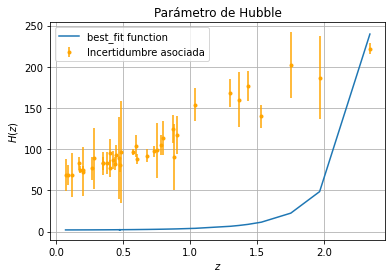

In [2147]:
def best_fit(x):
    return x**3 + expo(x) * x**3 + x**2 + x**3 - ln(x)

def prueba(x):
    return expo(x)*expo(x)/expo(x)/(x)**2-ln((((ln(x)))**3))+(ln(x)) 

def prueba2(x):
    return ln(x)/ln(x)+expo((x)**2)

yerr = desv
plt.xlabel('$ z $')
plt.ylabel('$ H(z) $')
plt.title('Parámetro de Hubble')
plt.plot(z, prueba2(z), label= 'best_fit function')
plt.errorbar(z, H, yerr=yerr, fmt='.', color = 'orange', label = 'Incertidumbre asociada')
plt.legend()
plt.grid(True)
plt.show()